# Replication Code for "Predicting Human Mobility Using Dense Smartphone GPS Trajectories and Transformer Models"

## Disclaimer on Exact Reproducibility Across GPU Hardware

Even when every source of randomness is fully seeded (Python random, NumPy, PyTorch, data‐loader workers), and the exact same library binaries (PyTorch 2.4.1+cu121, CUDA 12.1, cuDNN 9.1, NumPy 1.23.5, etc.) are installed, bit‐for‐bit identical results can only be guaranteed on the same GPU architecture. For example, our primary experiments were run on an NVIDIA RTX A5000 (Driver 560.35.05, CUDA 12.6), and the deterministic cuDNN kernels selected on that card produce a very specific floating‐point rounding path. Colab typically provides T4, P100, or V100 GPUs, which—even under a “deterministic” build of cuDNN—invoke different optimized kernels and may accumulate minute floating‐point differences over hundreds of weight updates. As a result, anyone who is running the same code on Colab GPUs should expect functionally equivalent behavior (identical losses up to ≈1e-6), but they will not see precisely the same final weights or epoch‐by‐epoch outputs unless they use an RTX A5000 (or another card with identical compute capability and driver).

## Setting up environment

In [ ]:
# Uninstall pre-installed torch, torchvision, torchaudio, numpy
!pip uninstall -y torch torchvision torchaudio numpy

Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2


In [ ]:
# Install torch 2.4.1+cu121, torchvision 0.19.1+cu121 and torchaudio 2.4.1+cu121
!pip install \
    torch==2.4.1+cu121 \
    torchvision==0.19.1+cu121 \
    torchaudio==2.4.1+cu121 \
    --extra-index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 117.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 88.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

Import modules PyTorch and Numpy, which will be used in model training.

In [ ]:
import torch
import numpy as np
print("Colab PyTorch:", torch.__version__, "CUDA:", torch.version.cuda, "cuDNN:", torch.backends.cudnn.version())
print("NumPy:", np.__version__)

Colab PyTorch: 2.4.1+cu121 CUDA: 12.1 cuDNN: 90100
NumPy: 2.3.4


## Downloading Replication Code and Data

This section downloads the published codebase (_SpeedTransformer_) and the three pre‑processed datasets (_MOBIS_, _GeoLife_, and _Miniprogram_) exactly as referenced in **Section “Data and Codes Availability”**.  
The repository zip is fetched from Zenodo and unzipped into the Colab working directory.  
The subsequent cell creates a `data/` folder where the CSV files are stored so that the training scripts can locate them via the relative paths used throughout the notebook.

In [ ]:
!wget https://zenodo.org/records/17429944/files/SpeedTransformer.zip -O /content/SpeedTransformer.zip
!unzip /content/SpeedTransformer.zip

--2025-10-28 15:14:11--  https://zenodo.org/records/17429944/files/SpeedTransformer.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25755626 (25M) [application/octet-stream]
Saving to: ‘/content/SpeedTransformer.zip’

/content/SpeedTrans 100%[===================>]  24.56M   270KB/s    in 90s     

2025-10-28 15:15:42 (278 KB/s) - ‘/content/SpeedTransformer.zip’ saved [25755626/25755626]

Archive:  /content/SpeedTransformer.zip
   creating: SpeedTransformer/
  inflating: __MACOSX/._SpeedTransformer  
  inflating: SpeedTransformer/SpeedTransformer.ipynb  
  inflating: __MACOSX/SpeedTransformer/._SpeedTransformer.ipynb  
  inflating: SpeedTransformer/.DS_Store  
  inflating: __MACOSX/SpeedTransformer/._.DS_Store  
   creating: SpeedTransformer/models/
  inflating: __MACOSX/SpeedTransformer/._models  
  inflating: SpeedTran

In [ ]:
# Download CSV files into the data/ directory
!wget -O /content/SpeedTransformer/data/mobis_processed.csv https://zenodo.org/record/17429944/files/mobis_processed.csv
!wget -O /content/SpeedTransformer/data/geolife_processed.csv https://zenodo.org/record/17429944/files/geolife_processed.csv
!wget -O /content/SpeedTransformer/data/miniprogram_balanced.csv https://zenodo.org/record/17429944/files/miniprogram_balanced.csv

--2025-10-26 20:59:43--  https://zenodo.org/record/17429944/files/mobis_processed.csv
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/17429944/files/mobis_processed.csv [following]
--2025-10-26 20:59:44--  https://zenodo.org/records/17429944/files/mobis_processed.csv
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 31273348118 (29G) [text/plain]
Saving to: ‘/content/SpeedTransformer/data/mobis_processed.csv’

nt/SpeedTransformer  82%[===============>    ]  24.03G  13.5MB/s    eta 6m 26s ^C
--2025-10-26 21:30:08--  https://zenodo.org/record/17429944/files/geolife_processed.csv
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request 

Organize the data files.

In [ ]:
!mv /content/SpeedTransformer /content/A-SpeedTransformer

Move data to a Google Cloud Storage. Import it later after switching to a GPU node later.

In [ ]:
# === Configuration ===
PROJECT_ID = "osmandgdelt" # switch to your project_id
BUCKET_NAME = "speed_transformer"  # switch to your bucket name
BUCKET_LOCATION = "us-west1"          # switch to a region close to you
LOCAL_DIR = "/content/A-SpeedTransformer" # your local source directory
GCS_PREFIX = "speed_transformer"  # folder-like prefix in the bucket

# === Install and authenticate ===
%pip -q install -U google-cloud-storage gcsfs

from google.colab import auth
auth.authenticate_user()  # login to your Google account
print("Authenticated.")

# === Create bucket if it doesn't exist ===
import google.cloud.storage as gcs

client = gcs.Client(project=PROJECT_ID)
existing = [b.name for b in client.list_buckets() if b.name == BUCKET_NAME]
if not existing:
    bucket = client.bucket(BUCKET_NAME)
    bucket.storage_class = "STANDARD"
    client.create_bucket(bucket, location=BUCKET_LOCATION)
    print(f"Created bucket: gs://{BUCKET_NAME}/ in {BUCKET_LOCATION}")
else:
    print(f"Bucket exists: gs://{BUCKET_NAME}/")

# === (Option 1) Fast, robust upload with gsutil (recommended for large trees) ===
# Preserves filenames exactly; parallelized and resumable.
import subprocess, shlex
cmd = f'gsutil -m rsync -r -d "{LOCAL_DIR}" "gs://{BUCKET_NAME}/{GCS_PREFIX}"'
print(cmd)
subprocess.check_call(shlex.split(cmd))
print("Upload complete via gsutil rsync.")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 9.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-aiplatform 1.121.0 requires google-cloud-storage<3.0.0,>=1.32.0, but you have google-cloud-storage 3.4.1 which is incompatible.
google-adk 1.16.0 requires google-cloud-storage<3.0.0,>=2.18.0, but you have google-cloud-storage 3.4.1 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
Authenticated.
Bucket exists: gs://speed_transformer/
gsutil -m rsync -r -d "/content/A-SpeedTransformer" "gs://speed_transformer/speed_transformer"
Upload complete via gsutil rsync.


Re-import the data from Google Cloud Storage

In [ ]:
# === Configuration ===
PROJECT_ID = "osmandgdelt"
BUCKET_NAME = "speed_transformer"           # your existing bucket
GCS_PREFIX = "speed_transformer"            # folder prefix in GCS
LOCAL_DIR = "/content/A-SpeedTransformer"   # local target directory (important!)

# === Install and authenticate ===
%pip -q install -U google-cloud-storage gcsfs

from google.colab import auth
auth.authenticate_user()  # log in again after switching runtime
print("✅ Authenticated with Google account")

# === Ensure the target directory exists ===
import os
os.makedirs(LOCAL_DIR, exist_ok=True)

# === Sync data from GCS to local ===
import subprocess, shlex

cmd = f'gsutil -m rsync -r "gs://{BUCKET_NAME}/{GCS_PREFIX}" "{LOCAL_DIR}"'
print(f"Running: {cmd}")
subprocess.check_call(shlex.split(cmd))

print(f"✅ Download complete. Files restored to {LOCAL_DIR}")
!ls -lh "{LOCAL_DIR}"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 23.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-aiplatform 1.121.0 requires google-cloud-storage<3.0.0,>=1.32.0, but you have google-cloud-storage 3.4.1 which is incompatible.
google-adk 1.16.0 requires google-cloud-storage<3.0.0,>=2.18.0, but you have google-cloud-storage 3.4.1 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
✅ Authenticated with Google account
Running: gsutil -m rsync -r "gs://speed_transformer/speed_transformer" "/content/A-SpeedTransformer"
✅ Download complete. Files restored to /content/A-SpeedTransformer
total 200K
drwxr-xr-x 2 root root 4.0K Oct 26 21:34 data
drwxr-xr-x 6 root root 4

## Main Text-Training Benchmark Runs: LSTM and SpeedTransformer on Geolife & MOBIS


Trains SpeedTransformer and the LSTM baseline from scratch on both MOBIS and Geolife. It rebuilds the headline benchmark comparisons—overall accuracy, convergence curves, and class-level F1 scores—used in Section 5 “Experiments” (see Tables 2-3 and Figures 3–4) in the main text. The figures will be illustrated in the last cellblock in this Colab, using the results here. These outputs show how the transformer surpasses the LSTM when both see the full datasets with identical preprocessing.

In [ ]:
%cd /content/
!bash A-SpeedTransformer/models/replication/run_training_experiments.sh

/content
\n[Transformer] Geolife → lr2e-4_bs512_h8_d128_kv4_do0.1
2025-10-25 18:40:39,485 - INFO - Setting random seed to 316
2025-10-25 18:40:39,485 - INFO - DDP world_size=1 local_rank=0
2025-10-25 18:40:39,488 - INFO - Initializing DataProcessor...
Extracting unique trajectory IDs...
Reading traj_ids: 5it [00:02,  2.25it/s]
Total unique traj_ids found: 9347
Splitting traj_ids into train, validation, and test sets...
Train: 6542, Val: 1402, Test: 1403
Fitting label encoder on target column...
Reading labels for encoding: 5it [00:02,  2.41it/s]
Classes found: ['bike' 'bus' 'car' 'train' 'walk']
Fitting scaler on training features...
Reading training features for scaling: 5it [00:02,  1.95it/s]
Scaler fitting completed.
Creating sequences in sliding windows...
Processing chunks: 5it [00:10,  2.05s/it]
Train: 51515, Val: 10762, Test: 10729
Skipped sequences (zero length): 0
Scaler saved to /content/A-SpeedTransformer/models/transformer/experiments/geolife_transformer_sweeps/lr2e-4_bs512

## Appendix F Slide-Window Sweep Using Geolife Data

We test the effect of the sliding window size by varying the size between 20 and 500.

Repeats the Geolife sliding-window size sweep, holding all hyperparameters constant while varying the context length fed to the transformer. The results, reproduced in Figure F1 and Table F1, confirm that a window size of T = 200 is optimal and therefore adopted throughout the paper.

In [ ]:
!bash A-SpeedTransformer/models/replication/run_window_sweep_experiments.sh

[Window Sweep] Geolife → geolife_ws200_lr2e-4_bs512_h8_d128_kv4_do0.1
2025-10-26 04:01:17,637 - INFO - Setting random seed to 316
2025-10-26 04:01:17,637 - INFO - DDP world_size=1 local_rank=0
2025-10-26 04:01:17,638 - INFO - Initializing DataProcessor...
Extracting unique trajectory IDs...
Reading traj_ids: 5it [00:02,  2.21it/s]
Total unique traj_ids found: 9347
Splitting traj_ids into train, validation, and test sets...
Train: 6542, Val: 1402, Test: 1403
Fitting label encoder on target column...
Reading labels for encoding: 5it [00:02,  2.40it/s]
Classes found: ['bike' 'bus' 'car' 'train' 'walk']
Fitting scaler on training features...
Reading training features for scaling: 5it [00:02,  1.91it/s]
Scaler fitting completed.
Creating sequences in sliding windows...
Processing chunks: 5it [00:10,  2.04s/it]
Train: 51515, Val: 10762, Test: 10729
Skipped sequences (zero length): 0
Scaler saved to /content/A-SpeedTransformer/models/transformer/experiments/geolife_window_sweeps/geolife_ws200

## Appendix C Full Geolife Finetuning



See the section on cross-dataset transfer (MOBIS → Geolife). We initialize the model with MOBIS-pretrained checkpoints and fine-tune it on labeled Geolife trips. The resulting checkpoints and training logs produce the per-class F1-score results reported in Appendix C (Figure C1).

In [ ]:
!bash A-SpeedTransformer/models/replication/run_gl_finetune_experiments.sh

\n[Transformer Finetune] Geolife → lr2e-4_warmup0_freeze_attention
2025-10-26 04:06:58,521 - INFO - Initializing DataProcessor for fine-tuning...
Extracting unique trajectory IDs...
Reading traj_ids: 5it [00:02,  2.22it/s]
Total unique traj_ids found: 9347
Splitting traj_ids into train, validation, and test sets...
Train: 93, Val: 1869, Test: 7385
Fitting label encoder on target column...
Reading labels for encoding: 5it [00:02,  2.41it/s]
Classes found: ['bike' 'bus' 'car' 'train' 'walk']
Fitting scaler on training features...
Reading training features for scaling: 5it [00:02,  1.93it/s]
Scaler fitting completed.
Creating sequences in sliding windows...
Processing chunks: 5it [00:10,  2.05s/it]
Train: 899, Val: 16344, Test: 55763
Skipped sequences (zero length): 0
Creating sequences in sliding windows...
Processing chunks: 5it [00:10,  2.01s/it]
Train: 899, Val: 16344, Test: 55763
Skipped sequences (zero length): 0
/content/A-SpeedTransformer/models/transformer/model_utils.py:231: Fut

## Main Text and Appendix C Fine-Tuning on Geolife

Starts from MOBIS-pretrained checkpoints and fine-tunes on 100 and 200 labeled Geolife trips. The resulting checkpoints and logs feed the low-shot transfer analysis in Section 5.2 (Table 4), demonstrating that SpeedTransformer retains strong accuracy with only 10-20% of the Geolife training trajectories. We report the per-class F1 results in Appendix C (Figure C1)

In [ ]:
!bash A-SpeedTransformer/models/replication/run_gl_lowshot_finetune_experiments.sh

\n[lowshot] Target train trajs: 100
  val_size=0.494597196961592, test_size=0.494704183160372
  transformer run=train100_lr2e-4_warmup0_freeze_attention
  transformer saved → /content/A-SpeedTransformer/models/transformer/experiments/finetune_lowshot/train100_lr2e-4_warmup0_freeze_attention
  lstm run=train100_lr5e-5_bs128_do0.3
  lstm saved → /content/A-SpeedTransformer/models/lstm/experiments/finetune_lowshot/train100_lr5e-5_bs128_do0.3
\n[lowshot] Target train trajs: 200
  val_size=0.489247887022574, test_size=0.489354873221354
  transformer run=train200_lr2e-4_warmup0_freeze_attention
  transformer saved → /content/A-SpeedTransformer/models/transformer/experiments/finetune_lowshot/train200_lr2e-4_warmup0_freeze_attention
  lstm run=train200_lr5e-5_bs128_do0.3
  lstm saved → /content/A-SpeedTransformer/models/lstm/experiments/finetune_lowshot/train200_lr5e-5_bs128_do0.3
\nLow-shot Geolife finetuning runs completed.


## Main Text and Appendix C Fine-Tuning on Real-World App Experiment


Adapts both architectures to subsets of the real-world CarbonClever dataset
[15%, 20%, 30%, 40%, 50%] collected via the WeChat mini-app. The resulting checkpoints and logs feed the low-shot transfer analysis in Section 6.2 (Table 6), confirming SpeedTransformer’s robustness when confronted with noisy, heterogeneous smartphone GPS traces. We also report the per-class F1-score results in Appendix C (Figure C1).

In [ ]:
!bash A-SpeedTransformer/models/replication/run_miniprogram_finetune_experiments.sh

Missing LSTM pretrained weights at /content/A-SpeedTransformer/models/lstm/experiments/mobis_lstm_sweeps/mobis_lr1e-3_bs128_h128_l2_do0.1. Run the original MOBIS LSTM sweep to generate them.


## Main Results and Appendix C Figure Plotting

Consumes the artifacts from the five pipelines above—logs, metrics CSVs, best-model checkpoints—and regenerates every figure and the experiment summary table cited in the paper (Figures 3-4, C1, F1, Tables 4, 6, C1-8). Running it ensures the plots in the manuscript align exactly with the Colab notebook outputs.

In [ ]:
!python /content/A-SpeedTransformer/models/replication/metrics_gen.py

=== ANALYZING ALL EXPERIMENTS ===

Found experiments:
  Geolife: 8 Transformer, 8 LSTM
  Mobis: 8 Transformer, 7 LSTM
  Finetune Sweeps: 63 Transformer, 9 LSTM
  Miniprogram: 41 Transformer, 14 LSTM
  Geolife Window Sweeps: 7 Transformer
  Geolife Low-shot Finetune: 2 Transformer
Target params: {'lr': '2e-4', 'bs': 512, 'dropout': 0.1}
Target params: {'lr': '1e-4', 'bs': 512, 'dropout': 0.1}
Target params: {'lr': '2e-4'}
Target params: {'lr': '5e-4'}

=== FINDING BEST MATCHES FOR ORIGINAL EXPERIMENTS ===
Best Geolife Transformer: lr2e-4_bs512_h8_d128_kv4_do0.1 (acc: 0.9597)
Matching Geolife LSTM: geolife_lr5e-4_bs128_h256_l3_do0.1 (acc: 0.9240)
Best Mobis Transformer: mobis_lr1e-4_bs512_h8_d128_kv4_do0.1 (acc: 0.9422)
Matching Mobis LSTM: mobis_lr5e-4_bs128_h256_l3_do0.1 (acc: 0.9233)

=== BEST GEOLIFE TRANSFORMER RESULTS ===
1. lr2e-4_bs512_h8_d128_kv4_do0.1: 0.9597
2. lr2e-4_bs512_h8_d128_kv2_do0.1: 0.9536
3. lr2e-4_bs512_h12_d192_kv6_do0.1: 0.9472
4. lr2e-4_bs512_h8_d256_kv4_do0.1: 

NameError: name 'content' is not defined

Figure 3. Validation accuracies over epochs for Geolife and MOBIS. The SpeedTransformer consistently converges faster and achieves higher overall accuracy than the LSTM-Attention baseline on both datasets.

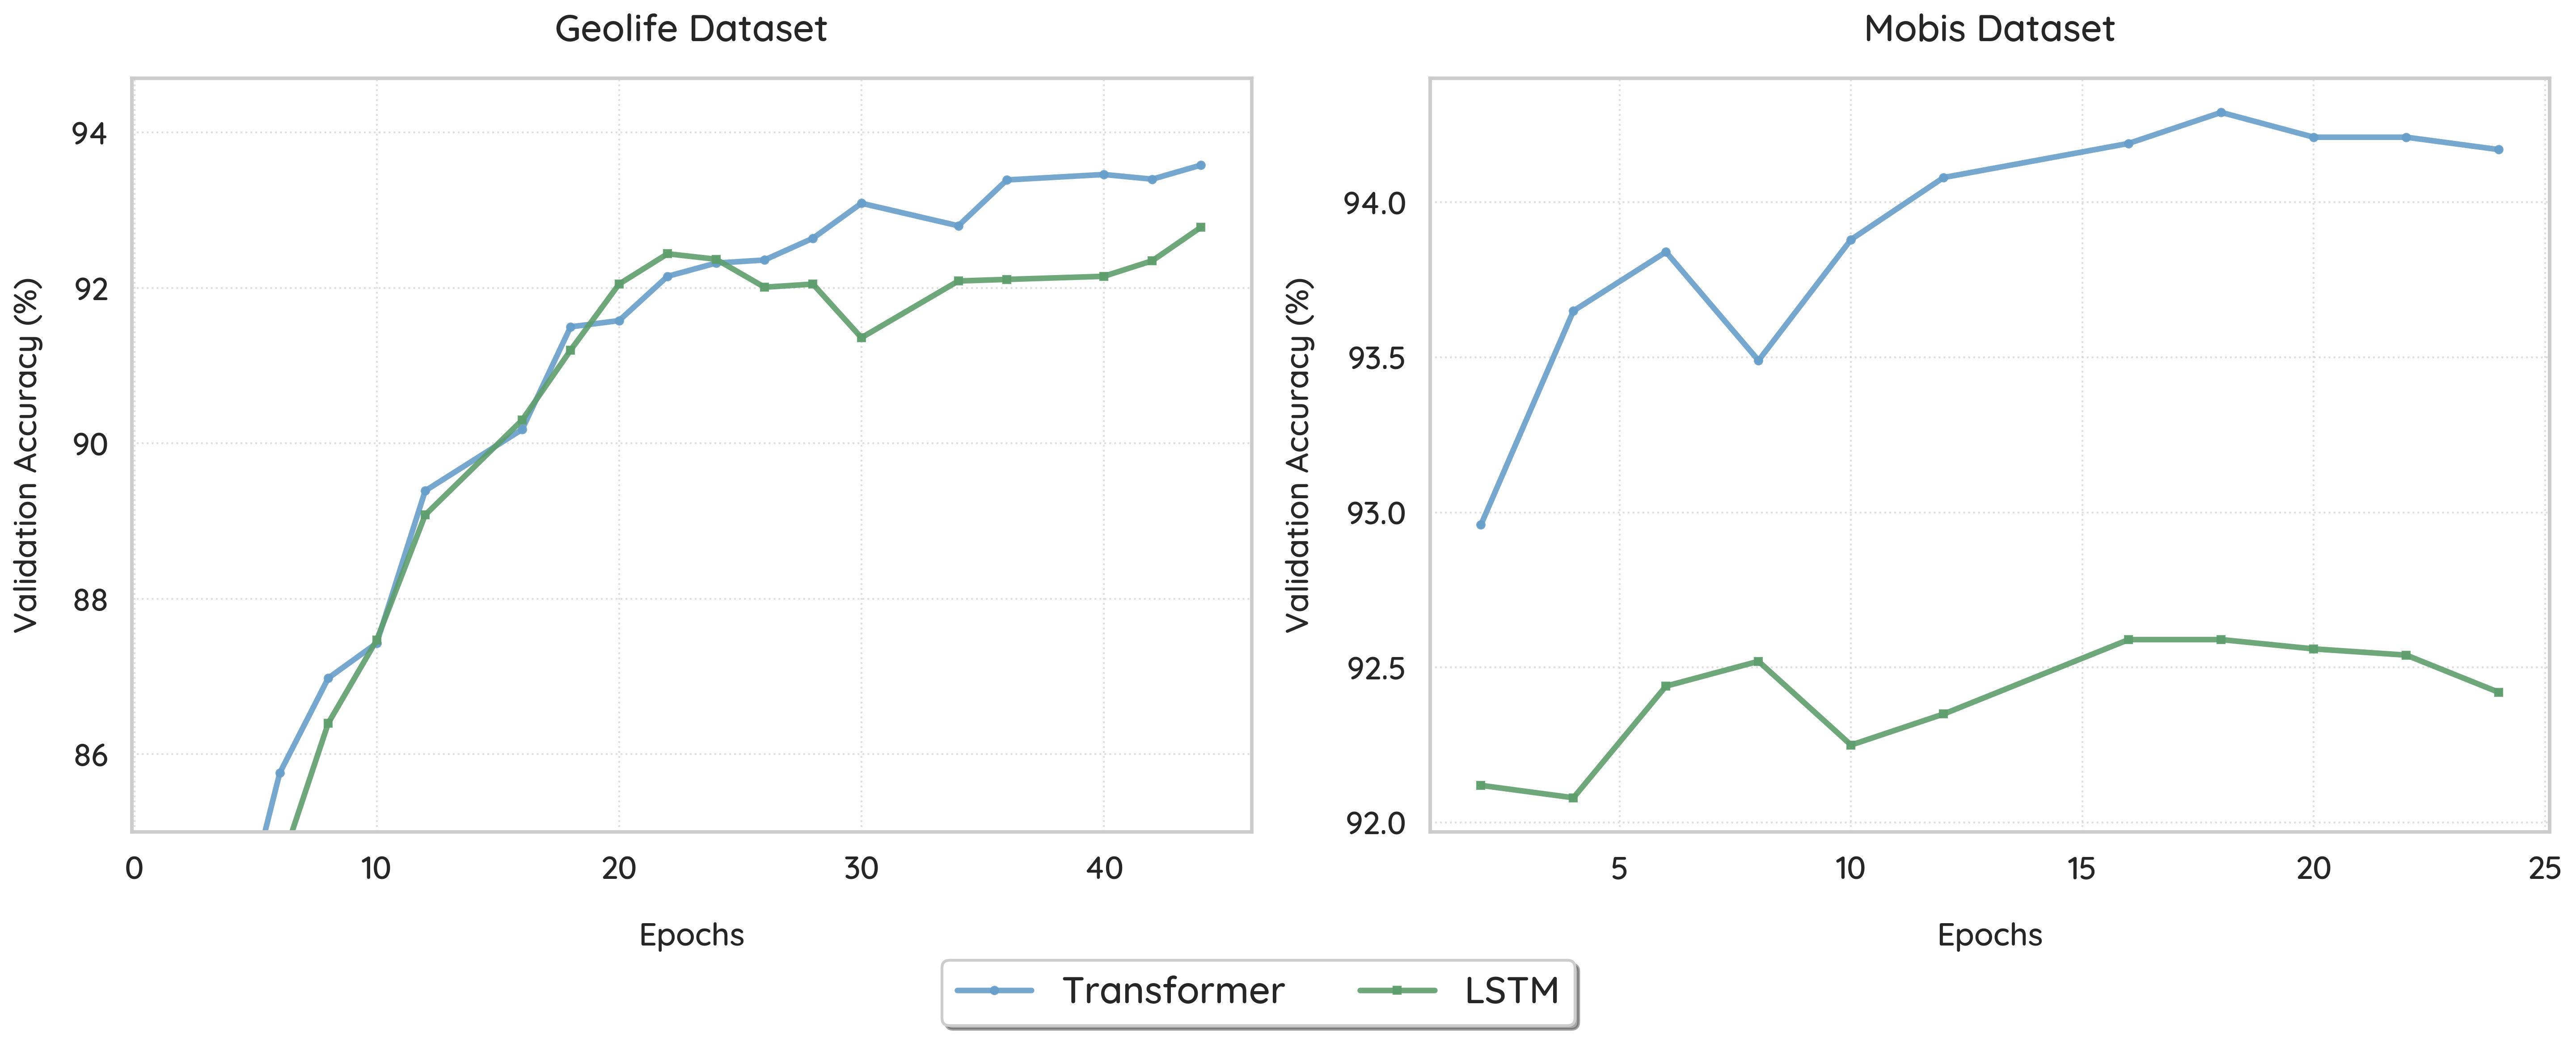

In [ ]:
from IPython.display import display, Image
image_path = '/content/A-SpeedTransformer/models/replication/Fig3_original_datasets_val_comparison.png'
display(Image(filename=image_path, width=1000))

Figure 4. Per class F1-Score for Geolife and MOBIS trainings using SpeedTransformer and LSTM. The SpeedTransformer consistently achieves better results than the LSTM-Attention across all classes on both datasets.


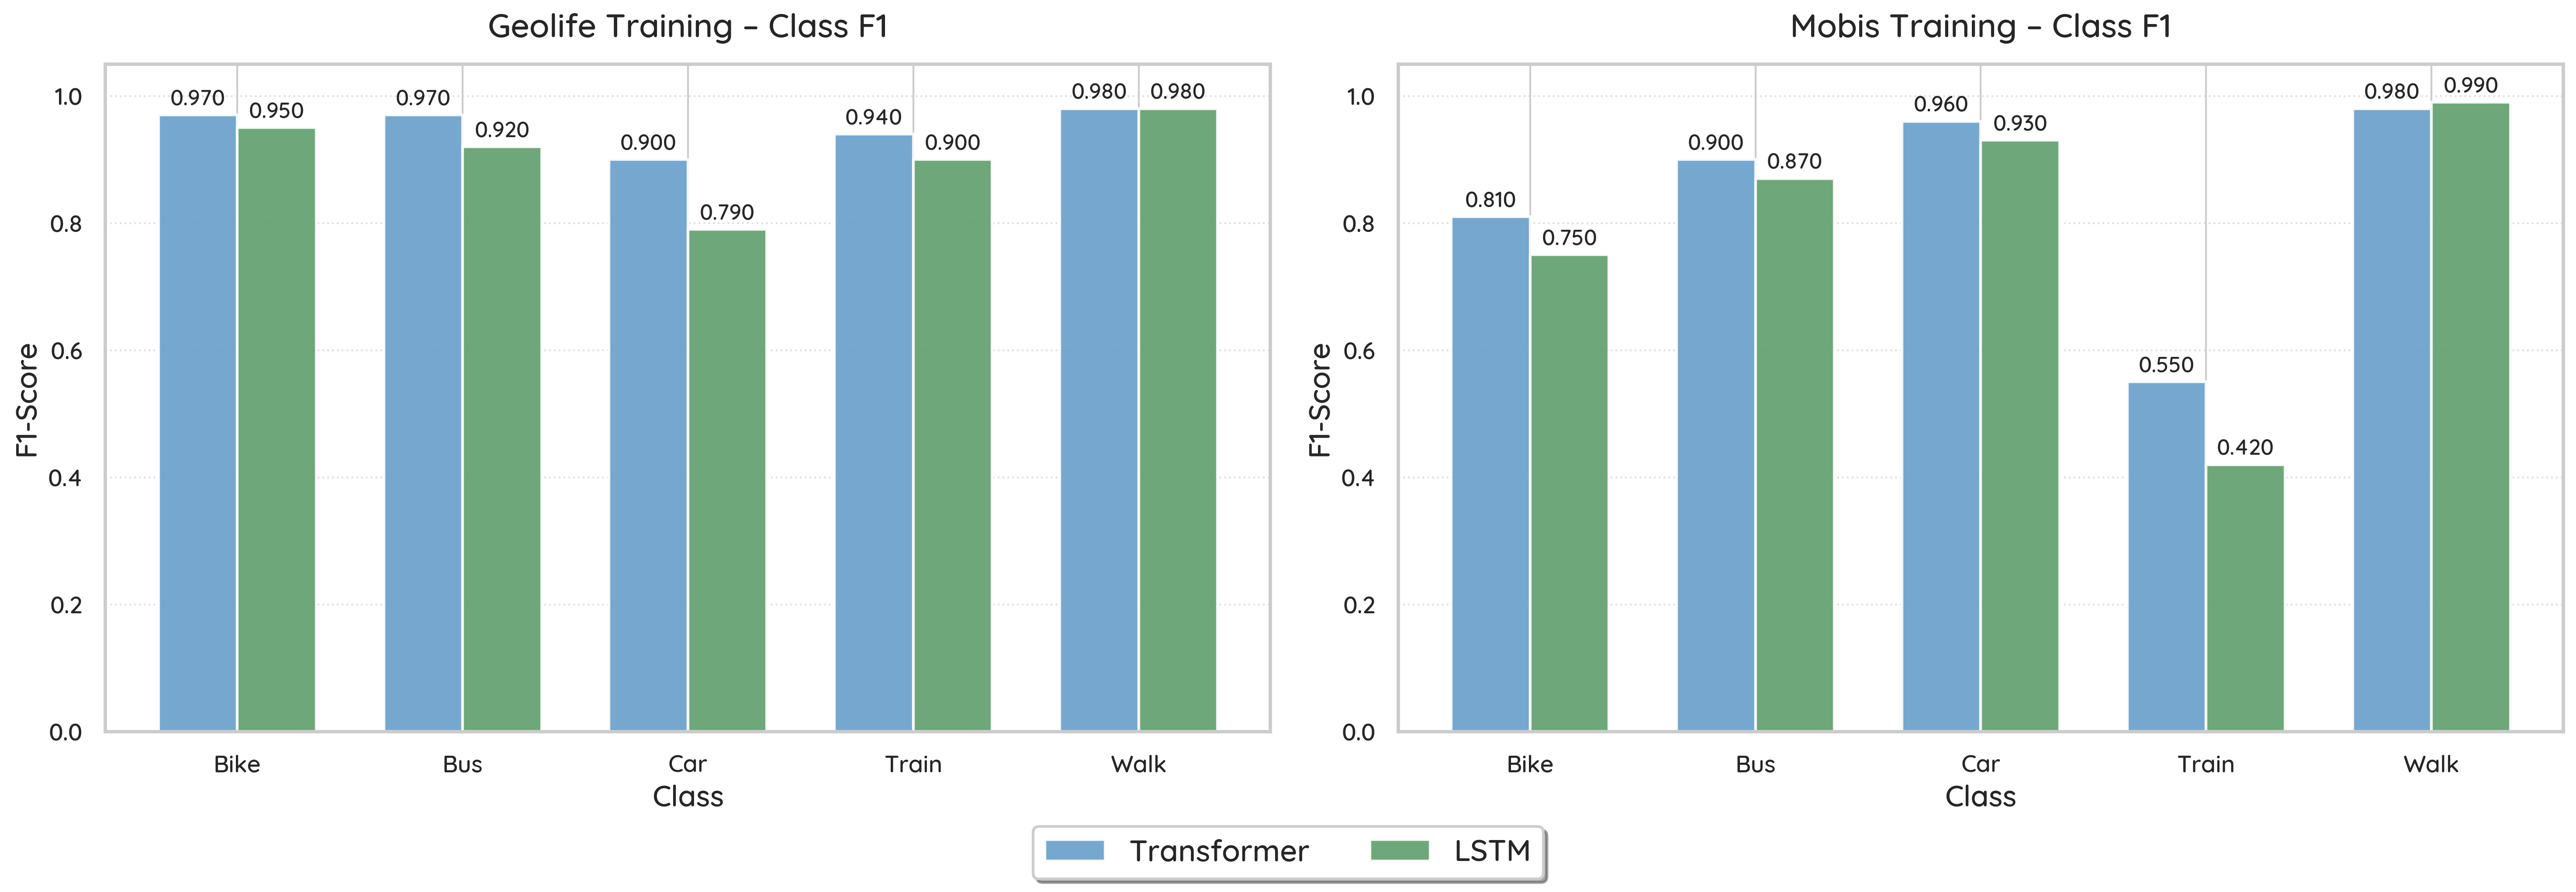

In [ ]:
from IPython.display import display, Image
image_path = '/content/A-SpeedTransformer/models/replication/Fig4_geolife_mobis_model_f1.png'
display(Image(filename=image_path, width=1000))

Figure C1. Per class F1-Score for finetuning Geolife and CarbonClever data using SpeedTransformer and LSTM pre-trained on MOBIS. The SpeedTransformer consistently achieves better results than the LSTM-Attention across all classes on both datasets.

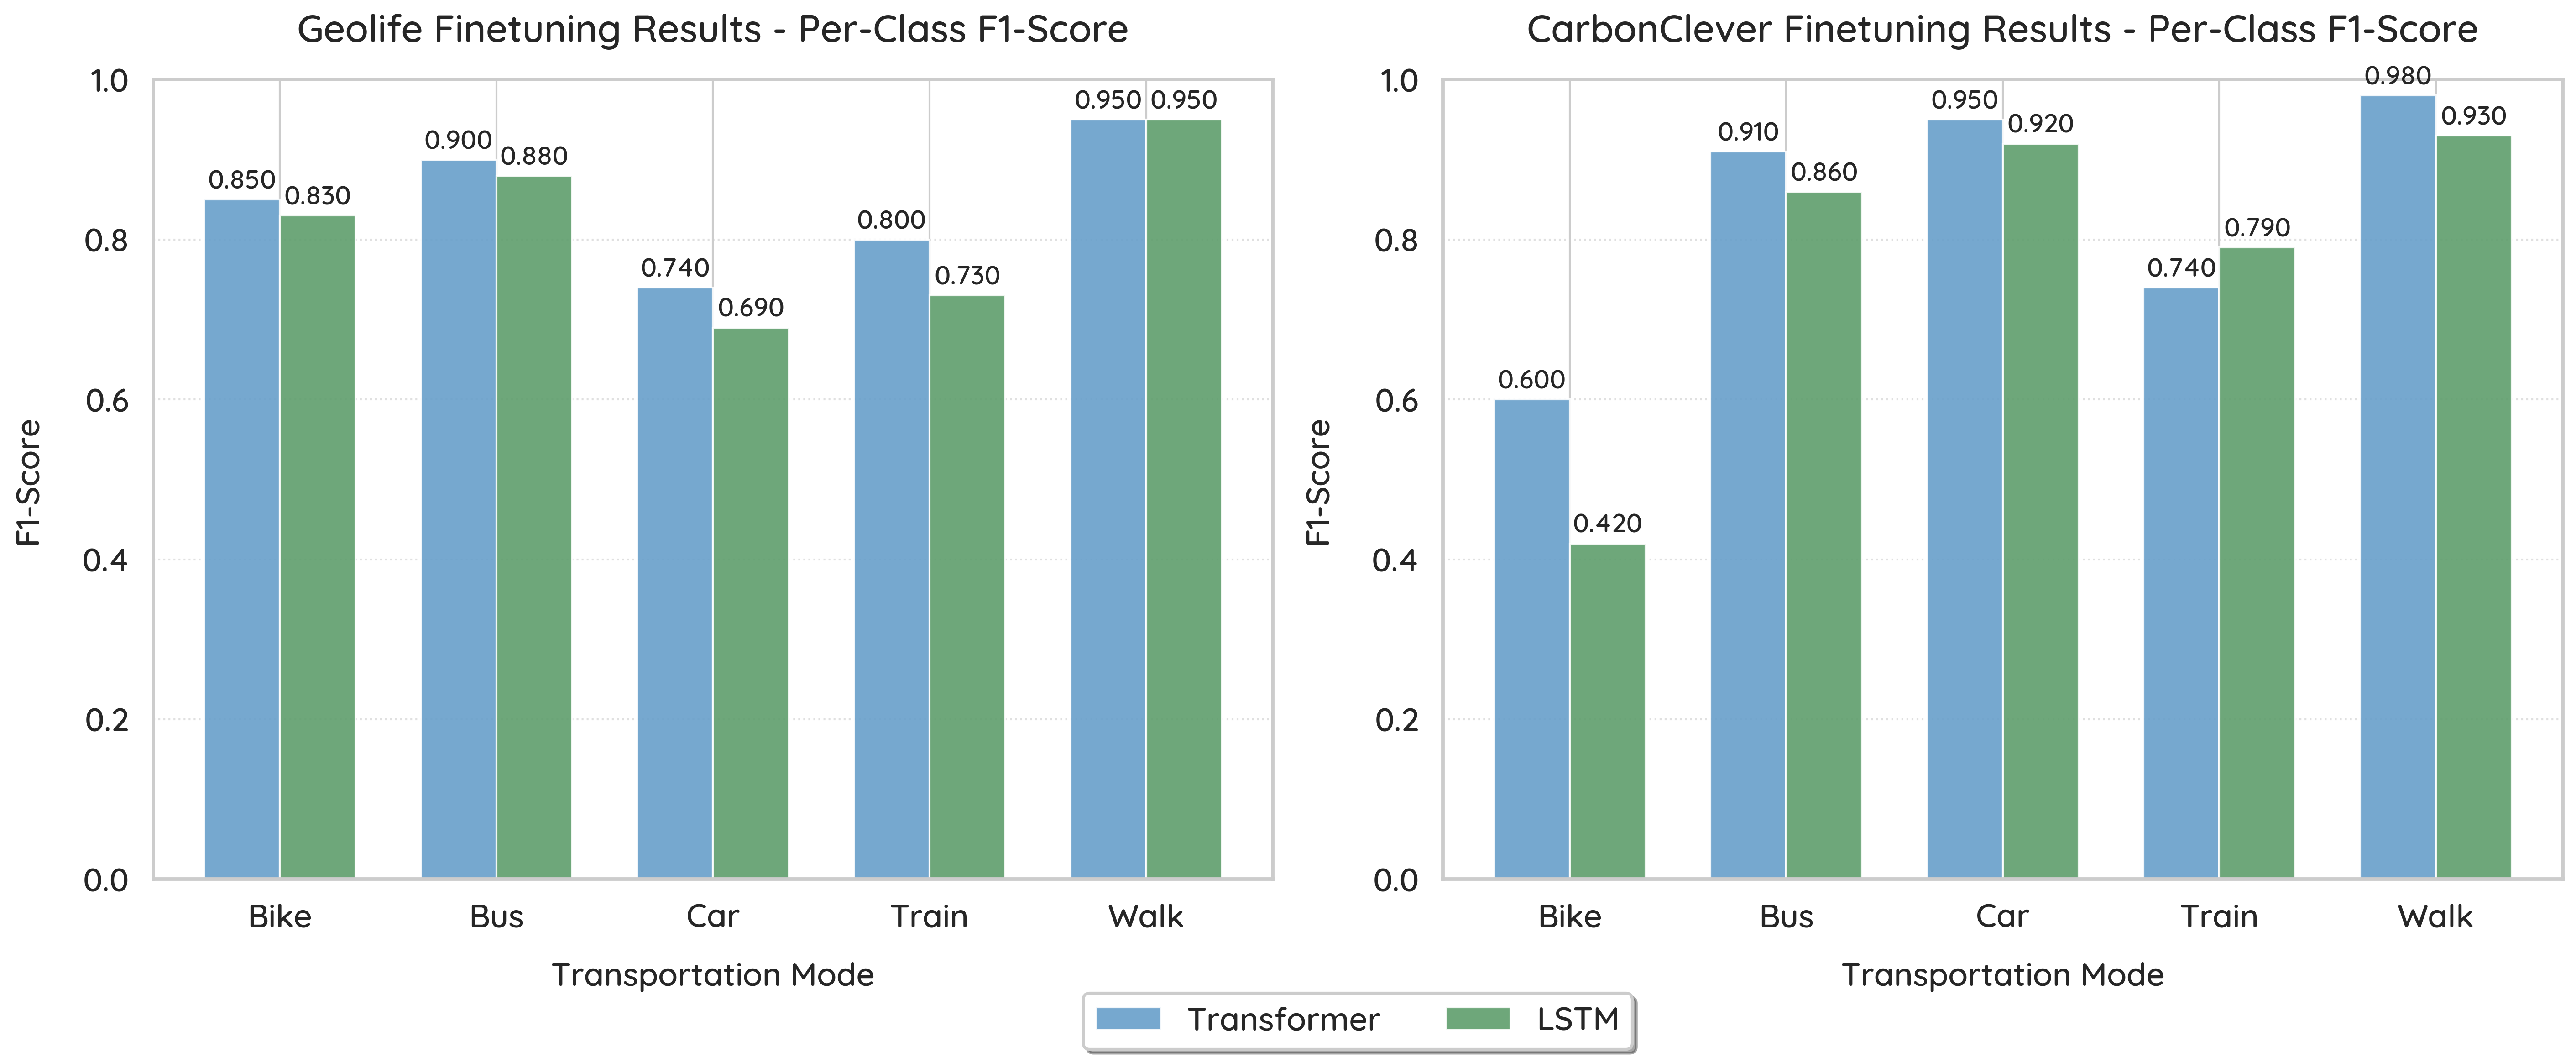

In [ ]:
from IPython.display import display, Image
image_path = '/content/A-SpeedTransformer/models/replication/FigC1_combined_per_class_f1.png'
display(Image(filename=image_path, width=1000))

Figure F1. :Effect of window size on test accuracy for the Geolife dataset. A window size of 200 provides the optimal balance between temporal context and computational efficiency, achieving the highest accuracy (95.97\%).

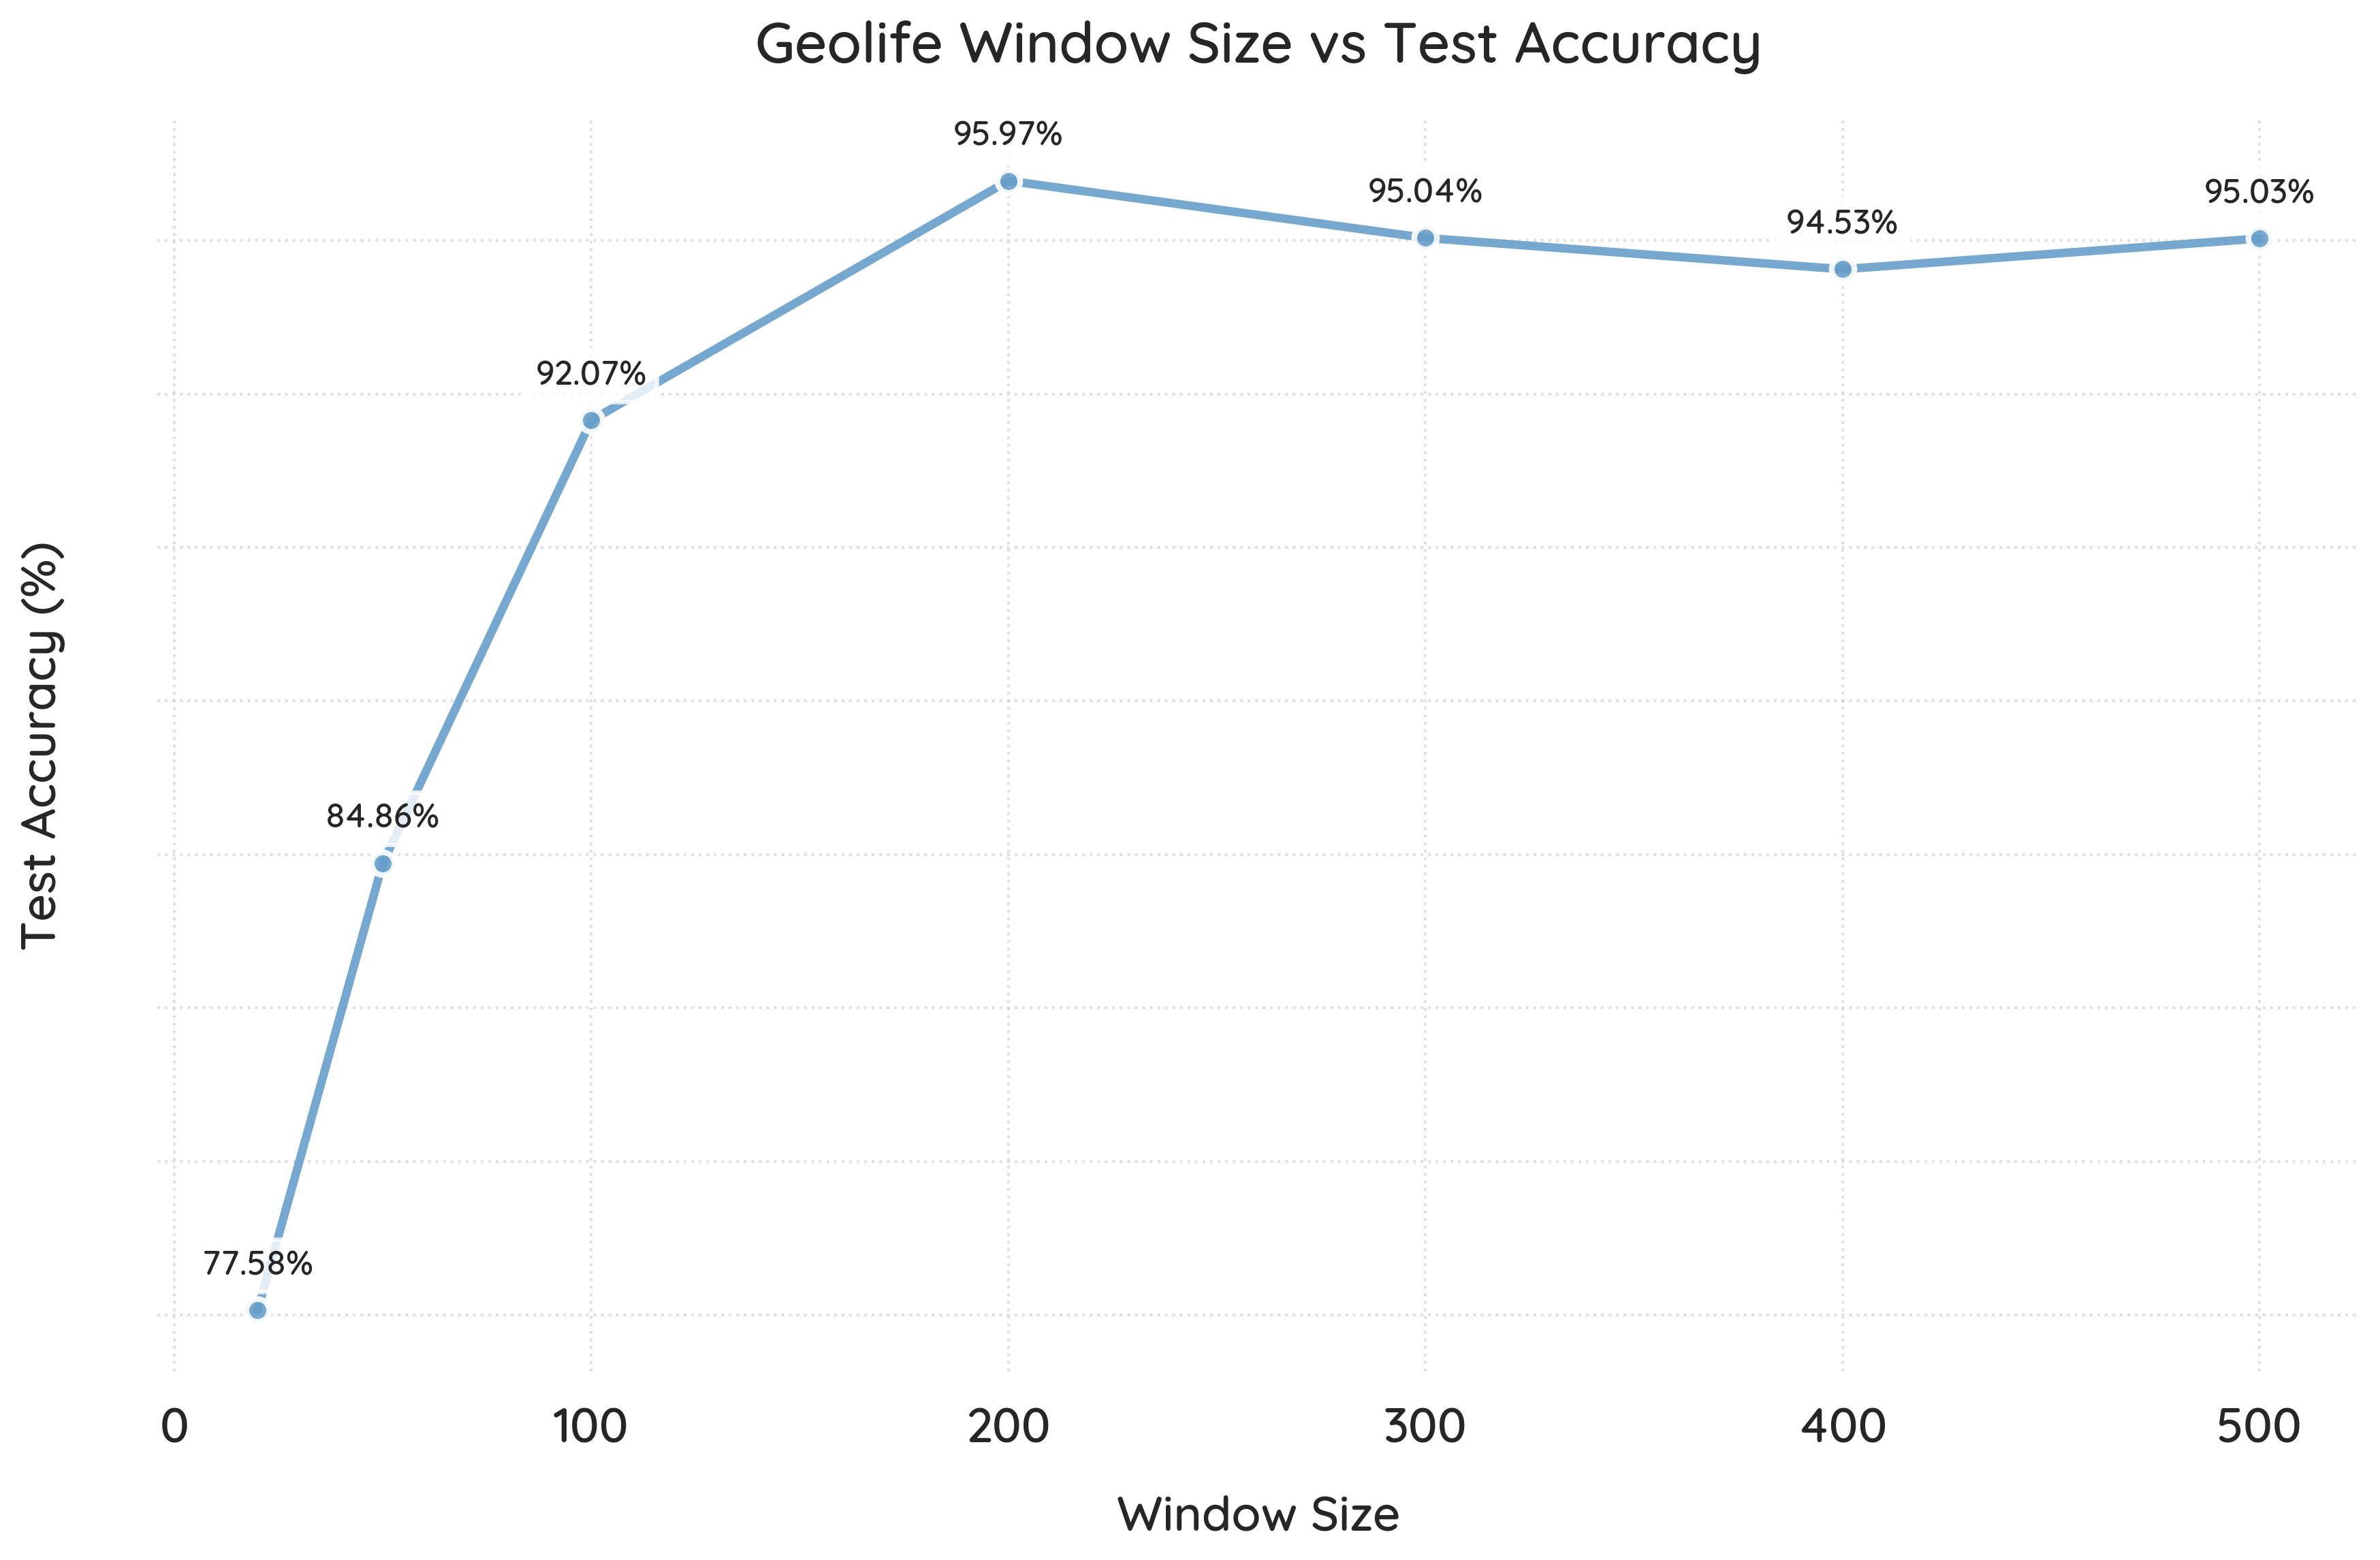

In [ ]:
from IPython.display import display, Image

image_path = '/content/A-SpeedTransformer/models/replication/FigF1_geolife_window_size_accuracy.png'
display(Image(filename=image_path, width=1000))